<a href="https://colab.research.google.com/github/Abhinandan-Pal/Deep-Forgery/blob/main/%3CGithub%3EForgery_Test_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#https://www.tensorflow.org/datasets/catalog/imagewang
#dataset

In [ ]:
!pip install -U tensorflow-addons

     |████████████████████████████████| 706kB 6.7MB/s 
  Found existing installation: tensorflow-addons 0.8.3
    Uninstalling tensorflow-addons-0.8.3:
      Successfully uninstalled tensorflow-addons-0.8.3


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import tensorflow as tf
import random
import numpy as np

In [ ]:
#may not need
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-y7idprx1
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-y7idprx1
  Created wheel for tensorflow-examples: filename=tensorflow_examples-0964dc3b7ae48033fd477a82be3c1572735e26f5_-cp36-none-any.whl size=188737 sha256=f360151d29a30cad35c69abfa82b00dc85cff4714e93bffb69ea167182685ff3
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlbmzuz_/wheels/83/64/b3/4cfa02dc6f9d16bf7257892c6a7ec602cd7e0ff6ec4d7d714d
Successfully built tensorflow-examples


In [ ]:
import tensorflow_addons as tfa

import tensorflow_datasets as tfds
#from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [ ]:
dataset, metadata = tfds.load('imagewang/320px',split= 'train',
                              with_info=True, as_supervised=True,shuffle_files=True)
dataset_val, metadata = tfds.load('imagewang/320px',split= 'validation',
                              with_info=True, as_supervised=True,shuffle_files=True)

#train_horses, train_zebras = dataset['trainA'], dataset['trainB']
#test_horses, test_zebras = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/imagewang/320px/2.0.0.incomplete83UVJ3/imagewang-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imagewang/320px/2.0.0.incomplete83UVJ3/imagewang-validation.tfrecord


Dataset imagewang downloaded and prepared to /root/tensorflow_datasets/imagewang/320px/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 10
IMG_WIDTH = 256
IMG_HEIGHT = 256

# **IMAGE PREPROCESS**

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.image.resize(image,[IMG_HEIGHT,IMG_WIDTH])
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def preprocess_image_orginal(image, label):
  image = normalize(image)
  return image

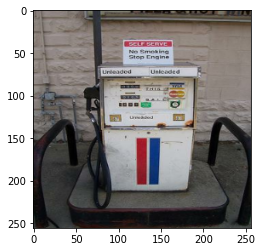

In [ ]:
for x,l in dataset.take(1):
  plt.imshow(preprocess_image_orginal(x,l)*0.5 + 0.5)


In [ ]:
def image__hsv_in_yiq(image):
  delta = 0.5
  lower_saturation = 0.1
  upper_saturation = 0.9
  lower_value = 0.2
  upper_value = 0.8
  image= tfa.image.random_hsv_in_yiq(image, delta, lower_saturation, upper_saturation, lower_value, upper_value)
  return image

In [ ]:
#There is some issue with this edit
def image_Dense_Image_Warp(image):
  input_img = tf.image.convert_image_dtype(tf.expand_dims(image, 0), tf.dtypes.float32)

  flow_shape = [1, input_img.shape[1], input_img.shape[2], 2]
  init_flows = np.float32(np.random.normal(size=flow_shape) * 1)
  dense_img_warp = tfa.image.dense_image_warp(input_img, init_flows)
  image = tf.squeeze(dense_img_warp, 0)
  return image

In [ ]:
def gen_rotate(image):
  image = tfa.image.rotate(image, tf.constant(np.pi/ random.randrange(32,128)))
  return image

In [ ]:
def gen_transform(image):
  n = 0.3
  rand = np.random.rand(6)*n-n/2
  image = tfa.image.transform(image, [1.0 + rand[0], 0.0 + rand[1], 0.0 + rand[2], 0.0 + rand[3], 1.0 + rand[4], 0.0 + rand[5], 0.0, 0.0])
  return image

In [ ]:
def gen_median_filter2d(image):
  image = tfa.image.median_filter2d(image, filter_shape=5)
  return image

In [ ]:
def gen_mean_filter2d(image):
  image = tfa.image.mean_filter2d(image, filter_shape=5)
  return image

In [ ]:
def generate_edit(image,label):
  image = normalize(image)
  if(random.random()<0.9):
    image = gen_rotate(image)
  if(random.random()<0.9):
    image = gen_transform(image)
  #if(random.random()<0.6):
    #image = image_Dense_Image_Warp(image)
  if(random.random()<0.6):
    image = image__hsv_in_yiq(image)
  if(random.random()<0.6):
    rn = random.random();
    if(rn<0.5):
      image = gen_median_filter2d(image)
    elif(rn<1):
      image = gen_mean_filter2d(image)
  return image

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


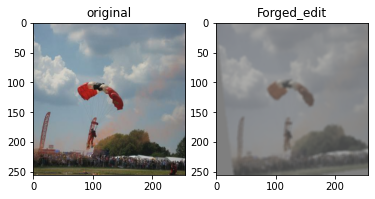

In [ ]:
for x,l in dataset.take(5):  
  plt.subplot(121)
  plt.title('original')
  plt.imshow(preprocess_image_orginal(x,l) * 0.5 + 0.5)

  plt.subplot(122)
  plt.title('Forged_edit')
  plt.imshow(generate_edit(x,l) * 0.5 + 0.5)

In [ ]:
original = dataset.map(
    preprocess_image_orginal, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

Forged_detectable  = dataset.map(
    generate_edit, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)    

test_original= dataset_val.map(
    preprocess_image_orginal, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1)

test_Forged_detectable = dataset_val.map(
    generate_edit, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(1) 

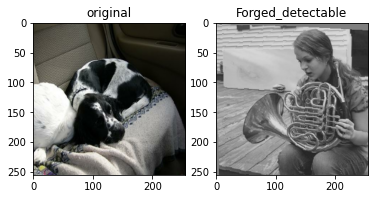

In [ ]:
sample_original = next(iter(original))
sample_Forged_detectable = next(iter(Forged_detectable))

plt.subplot(121)
plt.title('original')
plt.imshow(sample_original[0] * 0.5 + 0.5)

plt.subplot(122)
plt.title('Forged_detectable')
plt.imshow(sample_Forged_detectable[0] * 0.5 + 0.5)

# **Create Model**

In [ ]:
def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result

In [ ]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [ ]:
def discriminator(norm_type='batchnorm'):
  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      tf.keras.layers.MaxPooling2D(), #(bs, 64, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      tf.keras.layers.MaxPooling2D(), #(bs, 16, 16, 128) 
      downsample(128, 4, norm_type),  # (bs, 8, 8, 128)
      #tf.keras.layers.MaxPooling2D(),
      downsample(128, 4, norm_type),  # (bs, 4, 4, 128)
      downsample(256, 4, norm_type),  # (bs, 2, 2, 128)
      #tf.keras.layers.MaxPooling2D(),  # (bs, 1, 1, 128)
      #downsample(256, 4, norm_type),  
      downsample(512, 4, norm_type),  
      tf.keras.layers.Reshape((512,)),
      tf.keras.layers.Dense(128),
      tf.keras.layers.Dense(64),
      tf.keras.layers.Dense(1)

  ]

  initializer = tf.random_normal_initializer(0., 0.02)

  inputs = tf.keras.layers.Input(shape=[IMG_HEIGHT,IMG_WIDTH, 3])
  x = inputs

  for down in down_stack:
    x = down(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


# **Train Only Discrimnator**

In [ ]:
discriminator_is_forged = discriminator(norm_type='batchnorm')

In [ ]:
discriminator_is_forged.save_weights("/content/gdrive/My Drive/DeepForge/discriminator_is_forged_checkpoint" )


In [ ]:
discriminator_is_forged.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 128, 128, 64)      3072      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 32, 32, 128)       131584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 8, 8, 128)         262656    
_________________________________________________________________
sequential_3 (Sequential)    (None, 4, 4, 128)         262656

In [ ]:
#loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

loss_obj = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def discriminator_loss_single(predict, actual):

  if(actual == 1):
    return loss_obj(tf.ones_like(predict), predict)
  elif(actual == 0):
    return loss_obj(tf.zeros_like(predict), predict)

In [ ]:
discriminator_is_forged_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
def dis_onlyTrain_step(original, forged):
  with tf.GradientTape(persistent=True) as tape:
    predict_0 = discriminator_is_forged(original)
    predict_1 = discriminator_is_forged(forged)


    disc_is_forged_loss = discriminator_loss_single(predict_1, 1 ) + discriminator_loss_single(predict_0, 0 ) 


  discriminator_is_forged_gradients = tape.gradient( disc_is_forged_loss , discriminator_is_forged.trainable_variables)

  discriminator_is_forged_optimizer.apply_gradients(zip(discriminator_is_forged_gradients,
                                                discriminator_is_forged.trainable_variables))
  
  
  return (disc_is_forged_loss)

In [ ]:
EPOCHS_d = 10

In [ ]:
for epoch in range(EPOCHS_d):
  start = time.time()
  print("Batch : ")

  n = 0
  ep_loss = 0
  for image_x, image_y in tf.data.Dataset.zip((original, Forged_detectable)).take(5001):
    ep_loss = ep_loss + dis_onlyTrain_step(image_x, image_y)
    if n % 500 == 0:
      print ( str(n)+ " ", end='')
    n+=1
  

  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  #name = "Epoch : " + str(epoch) + "Image"

  if (True):
    ep_loss = ep_loss/n
    discriminator_is_forged.save_weights("/content/gdrive/My Drive/DeepForge/discriminator_is_forged_checkpoint" )
    print ('\nTime taken for epoch {} is {} sec. Loss : {} \n'.format(epoch + 1,
                                                      time.time()-start, ep_loss))

Batch : 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 
Time taken for epoch 1 is 1074.484703540802 sec. Loss : 0.10087992995977402 

Batch : 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 
Time taken for epoch 2 is 1095.2088742256165 sec. Loss : 0.034435637295246124 

Batch : 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 
Time taken for epoch 3 is 1096.7153725624084 sec. Loss : 0.03048420138657093 

Batch : 
0 500 1000 1500 2000 2500 3000 3500 4000 4500 5000 
Time taken for epoch 4 is 1115.3124480247498 sec. Loss : 0.03605092689394951 

Batch : 
0 500 

SystemError: ignored

In [ ]:
discriminator_is_forged.save_weights("/content/gdrive/My Drive/DeepForge/discriminator_is_forged_checkpoint" )


In [ ]:
def discriminator_accuracy(model,image_set, result):
  
  correct = 1 
  total = 1
  for image in image_set.take(100):
    predict = model(image)
    if(result == 0):
      if(predict.numpy() < 0.5):
        correct += 1
    if(result == 1):
      if(predict.numpy() > 0.5):
        correct += 1
    total = total +1
    print(predict.numpy())

  return (correct/total*100)
   

In [ ]:
acc = discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,0)#+ discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,1)
print(str(acc)+" %")

In [ ]:
acc = ( discriminator_accuracy(discriminator_is_forged,test_original ,0)+ discriminator_accuracy(discriminator_is_forged,test_Forged_detectable ,1) )/2
print(str(acc)+" %")

In [ ]:
0.00559938915754645*100

# **Whole Network Train**

In [ ]:
def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)


In [ ]:
OUTPUT_CHANNELS = 3

generator_detectable_FORGED_to_ORIGINAL = unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')
generator_ORIGINAL_to_detectable_FORGED = unet_generator(OUTPUT_CHANNELS, norm_type='batchnorm')

discriminator_is_forged = discriminator(norm_type='batchnorm')
discriminator_is_original = discriminator(norm_type='batchnorm')

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
loss_obj_disc = tf.keras.losses.MeanAbsoluteError()

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj_disc(tf.ones_like(real), real)

  generated_loss = loss_obj_disc(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [ ]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [ ]:
generator_detectable_FORGED_to_ORIGINAL_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_ORIGINAL_to_detectable_FORGED_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_is_forged_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_is_original_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_detectable_FORGED_to_ORIGINAL = generator_detectable_FORGED_to_ORIGINAL,
                           generator_ORIGINAL_to_detectable_FORGED = generator_ORIGINAL_to_detectable_FORGED,
                           discriminator_is_forged = discriminator_is_forged,
                           discriminator_is_original = discriminator_is_original,
                           generator_detectable_FORGED_to_ORIGINAL_optimizer = generator_detectable_FORGED_to_ORIGINAL_optimizer,
                           generator_ORIGINAL_to_detectable_FORGED_optimizer = generator_ORIGINAL_to_detectable_FORGED_optimizer,
                           discriminator_is_forged_optimizer = discriminator_is_forged_optimizer,
                           discriminator_is_original_optimizer = discriminator_is_original_optimizer
                           )

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [ ]:
def generate_images(model, test_input,epoch):
  prediction = model(test_input)
  f = plt.figure()  
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
@tf.function
def train_step(Orignial_img, Forged_img):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X
    
    # Goal : Make X like Y.
    
    Undectable_forged = generator_detectable_FORGED_to_ORIGINAL(Forged_img, training=True)
    cycled_forged = generator_ORIGINAL_to_detectable_FORGED(Undectable_forged, training=True)

    Made_forged = generator_ORIGINAL_to_detectable_FORGED(Orignial_img, training=True)
    cycled_original = generator_detectable_FORGED_to_ORIGINAL(Made_forged, training=True)

    # same_x and same_y are used for identity loss.
    same_forged = generator_ORIGINAL_to_detectable_FORGED(Forged_img, training=True)
    same_original = generator_detectable_FORGED_to_ORIGINAL(Orignial_img, training=True)

    disc_real_forged = discriminator_is_forged(Forged_img, training=True)
    disc_real_original = discriminator_is_original(Orignial_img, training=True)

    disc_fake_forged = discriminator_is_forged(Made_forged, training=True)
    disc_fake_original = discriminator_is_original(Undectable_forged , training=True)


    # calculate the loss
    gen_detectable_FORGED_to_ORIGINAL_loss = generator_loss(disc_fake_original)
    gen_ORIGINAL_to_detectable_FORGED_loss = generator_loss(disc_fake_forged)
    
    total_cycle_loss = calc_cycle_loss(Forged_img, cycled_forged) + calc_cycle_loss(Orignial_img, cycled_original)
    
    # Total generator loss = adversarial loss + cycle loss
    total_gen_detectable_FORGED_to_ORIGINAL_ORIGINAL_loss = gen_detectable_FORGED_to_ORIGINAL_loss + total_cycle_loss + identity_loss(Orignial_img, same_original)
    total_gen_ORIGINAL_to_detectable_FORGED_loss = gen_ORIGINAL_to_detectable_FORGED_loss + total_cycle_loss + identity_loss(Forged_img, same_forged)

    disc_is_forged_loss = discriminator_loss(disc_real_forged, disc_fake_forged)
    disc_is_original_loss = discriminator_loss(disc_real_original, disc_fake_original)
  
  # Calculate the gradients for generator and discriminator
  gen_detectable_FORGED_to_ORIGINAL_gradients = tape.gradient(total_gen_detectable_FORGED_to_ORIGINAL_ORIGINAL_loss, 
                                        generator_detectable_FORGED_to_ORIGINAL.trainable_variables)
  gen_ORIGINAL_to_detectable_FORGED_gradients = tape.gradient(total_gen_ORIGINAL_to_detectable_FORGED_loss, 
                                        generator_ORIGINAL_to_detectable_FORGED.trainable_variables)
  
  disc_is_forged_gradients = tape.gradient(disc_is_forged_loss, 
                                            discriminator_is_forged.trainable_variables)
  disc_is_original_gradients = tape.gradient(disc_is_original_loss, 
                                            discriminator_is_original.trainable_variables)
  print("Gen G Loss : "+str(total_gen_detectable_FORGED_to_ORIGINAL_ORIGINAL_loss)+" Gen F Loss : "+str(total_gen_ORIGINAL_to_detectable_FORGED_loss)+ " Disc_x Loss : "+ str(disc_is_forged_loss)+" Disc_y Loss : "+ str(disc_is_original_loss) )
  
  # Apply the gradients to the optimizer
  generator_detectable_FORGED_to_ORIGINAL_optimizer.apply_gradients(zip(gen_detectable_FORGED_to_ORIGINAL_gradients, 
                                            generator_detectable_FORGED_to_ORIGINAL.trainable_variables))

  generator_ORIGINAL_to_detectable_FORGED_optimizer.apply_gradients(zip(gen_ORIGINAL_to_detectable_FORGED_gradients, 
                                            generator_ORIGINAL_to_detectable_FORGED.trainable_variables))
  
  discriminator_is_forged_optimizer.apply_gradients(zip(disc_is_forged_gradients,
                                                discriminator_is_forged.trainable_variables))
  
  discriminator_is_original_optimizer.apply_gradients(zip(disc_is_original_gradients,
                                                discriminator_is_original.trainable_variables))

In [ ]:
sample_Forged_detectable = next(iter(Forged_detectable))

In [ ]:
EPOCHS = 1

<Figure size 432x288 with 0 Axes>

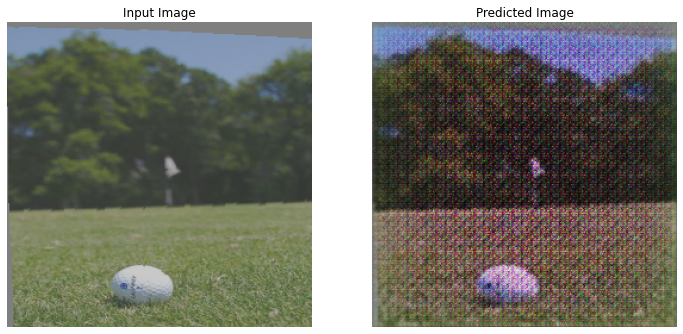

Saving checkpoint for epoch 1 at ./checkpoints/train/ckpt-1
Time taken for epoch 1 is 3489.1142444610596 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()
  print("Batch : ")

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((original, Forged_detectable)).take(500):#5001 to get proper results
    train_step(image_x, image_y)
    if n % 10 == 0:
      print ( str(n)+ " ", end='')
    n+=1

  clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  #name = "Epoch : " + str(epoch) + "Image"
  generate_images(generator_detectable_FORGED_to_ORIGINAL, sample_Forged_detectable,epoch)

  if (True):
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

# **Test**

In [ ]:
def discriminator_accuracy_Convert(model_d,model_g,image_set, result,conv):
  
  correct = 1 
  total = 1
  for image in image_set.take(100):
    if(conv == True):
      image = model_g(image)
    predict = model_d(image)
    if(result == 0):
      if(predict.numpy() < 0.5):
        correct += 1
    if(result == 1):
      if(predict.numpy() > 0.5):
        correct += 1
    total = total +1
    #print(predict.numpy())

  return (correct/total*100)


In [ ]:
acc = discriminator_accuracy_Convert(discriminator_is_forged, generator_detectable_FORGED_to_ORIGINAL, test_Forged_detectable ,0, False)#+ discriminator_accuracy_Convert(discriminator_is_forged,generator_detectable_FORGED_to_ORIGINAL,test_Forged_detectable ,1,False)


In [ ]:
acc = discriminator_accuracy_Convert(discriminator_is_forged,generator_detectable_FORGED_to_ORIGINAL,test_Forged_detectable ,0, True)#+ discriminator_accuracy_Convert(discriminator_is_forged,generator_detectable_FORGED_to_ORIGINAL,test_Forged_detectable ,1,False)


TypeError: ignored